# Whitening transform
This notebook explores the effects of the *whitening transform*
(and its subroutine, the *Cholesky decomposition*)
on a few isolated example inputs.

### Cholesky decomposition
Decompose a matrix $M$ into two matrices $W$ of the same shape,
such that
$M = WW^{\top}$.

Note that $M$ must be
1. Symmetric
2. Positive definite
(In the example below, a covariance matrix is used.
These are always symmetric and positive definite.)

Also, $W$ is always lower triangular (i.e. entries
above the main diagonal are always 0).

It is supposedly faster than the Eigenvalue-decomposition.
PyTorch implements both only on the CPU,
so I doubt either is particularly fast to use in Neural Networks.

In [19]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import timeit
import scipy.stats as stats
import pandas as pd

from typing import Any

from rolim.tools.stats import (sample_covar,
    randomized_multinormal_distr)
from rolim.tools.testing import assert_tensor_eq
from rolim.whitening.whitening import (
    whiten, whiten_naive, compute_whiten_error)

RNG = np.random.default_rng()

We begin with constructing a random
matrix that is symmetric and positive definite.
Covariance matrices always satisfy those requirements,
so compute the covariance matrix of a random collection of vectors:

In [20]:
shape = (3, 10)
elements = [x for x in range(shape[0]*shape[1])]
elements = RNG.permutation(elements)
sample = torch.tensor(elements, dtype=torch.float).reshape(shape)
m = sample_covar(sample)
m

tensor([[ 80.6778, -16.7556,  17.2444],
        [-16.7556,  99.6000,  32.0444],
        [ 17.2444,  32.0444,  39.8222]])

In [21]:
w = torch.linalg.cholesky(m)
print(w)
print(w @ w.T)
torch.allclose(m, w@w.T)

tensor([[ 8.9821,  0.0000,  0.0000],
        [-1.8654,  9.8041,  0.0000],
        [ 1.9199,  3.6338,  4.7887]])
tensor([[ 80.6778, -16.7556,  17.2444],
        [-16.7556,  99.6000,  32.0444],
        [ 17.2444,  32.0444,  39.8222]])


True

Note that $W$ is always lower-triangular.
So we can use torch's dedicated `torch.triangular_solve()`:

In [22]:
output = torch.triangular_solve(torch.eye(w.shape[0]), w)
print(output)
output[0] @ w

torch.return_types.triangular_solve(
solution=tensor([[0.1113, 0.0000, 0.0000],
        [0.0000, 0.1020, 0.0000],
        [0.0000, 0.0000, 0.2088]]),
cloned_coefficient=tensor([[ 8.9821,  0.0000,  0.0000],
        [-1.8654,  9.8041,  0.0000],
        [ 1.9199,  3.6338,  4.7887]]))


tensor([[ 1.0000,  0.0000,  0.0000],
        [-0.1903,  1.0000,  0.0000],
        [ 0.4009,  0.7588,  1.0000]])

The above does not seem very accurate.
`torch.linalg.inv()` does better:

In [23]:
torch.linalg.inv(w) @ w

tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.4901e-08,  1.0000e+00,  0.0000e+00],
        [-5.4106e-08, -1.8950e-08,  1.0000e+00]])

## Whitening transform on random 2D vectors
Experiment: sample random 2D vectors from multiple
(arbitrary) distributions, apply the whitening transform, and plot the results.

In [24]:
n1 = RNG.integers(low=10, high=100, dtype=int)
n2 = RNG.integers(low=10, high=100, dtype=int)
n3 = RNG.integers(low=10, high=100, dtype=int)

distr1 = torch.distributions.multivariate_normal.MultivariateNormal(
    loc = torch.tensor([10, 10], dtype=torch.float), 
    covariance_matrix=torch.eye(2, dtype=torch.float)
)

distr2 = torch.distributions.multivariate_normal.MultivariateNormal(
    loc = torch.tensor([-1, 0], dtype=torch.float), 
    covariance_matrix= torch.tensor([
        [3, 4], [4, 30]
    ], dtype=torch.float)
)

distr3 = torch.distributions.Poisson(rate=3)

In [34]:
sample1 = distr1.sample((n1,)).reshape((2, -1))
sample2 = distr2.sample((n2,)).reshape((2, -1))
sample3 = distr3.sample((2, n3))

sample = torch.concat((sample1, sample2, sample3), dim=1)
print(f"Generated random sample with shape: {sample.shape}")

whitened_sample = whiten(sample)

Generated random sample with shape: torch.Size([2, 133])


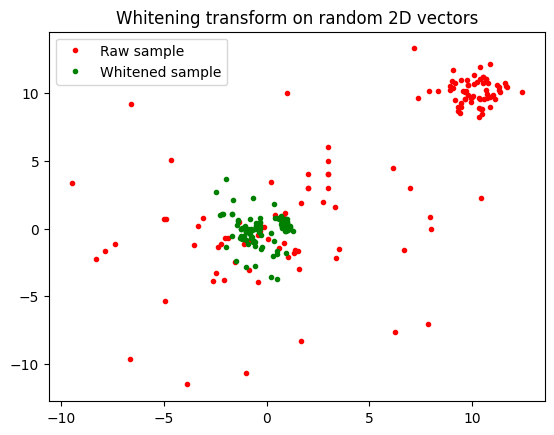

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(sample[0, :], sample[1, :], ".", color="red", label="Raw sample")
ax.plot(whitened_sample[0, :], whitened_sample[1, :], ".", color="green", label="Whitened sample")
ax.legend()
ax.set(**{"title": "Whitening transform on random 2D vectors"});

In [36]:
fig.savefig("effect_whitening.pdf")

## Is there a difference between whitening implementations?
The naive method first computes the covariance $\Sigma$,
inverts it, and decomposes it using Cholesky.
The alternative method used by various authors
computes $\Sigma$, regularizes it by blending
it with a diagonal matrix (to make it *numerically*
more likely to be positive definite, I suppose),
decomposes it, and then inverts the triangular matrix.

**Fun fact:** the LWM paper implements the regularization step,
but sets the parameter to 0, basically skipping it. 🤷

**Observation:** only the parameter $\epsilon$ seems to matter?
See plot below.

TODO: compare numerically, and compare computation speed.

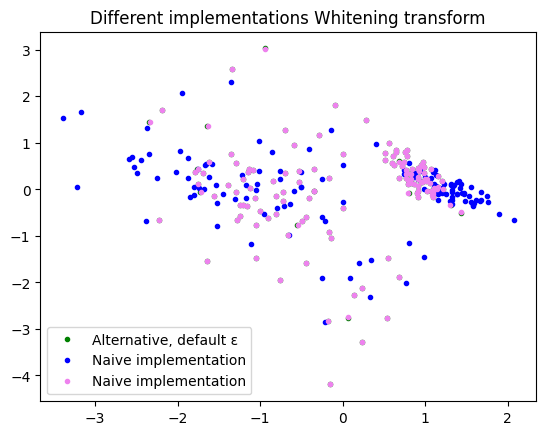

In [28]:
sample_naive_whitened = whiten_naive(sample)
sample_whitened_0_eps = whiten(sample, reg_eps=0)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(whitened_sample[0, :], whitened_sample[1, :], ".", color="green", label="Alternative, default ε")
ax.plot(sample_naive_whitened[0, :], sample_naive_whitened[1, :], ".", color="blue", label="Naive implementation")
ax.plot(sample_whitened_0_eps[0, :], sample_whitened_0_eps[1, :], ".", color="violet", label="Naive implementation")
ax.legend()
ax.set(**{"title": "Different implementations Whitening transform"});

### Random random distribution
Sample a random mean, a random covariance matrix,
and make a multinormal distribution from out
(sample the mean a standard multinormal distribution,
and the covariance as the covariance of a random standard mulinormal matrix).

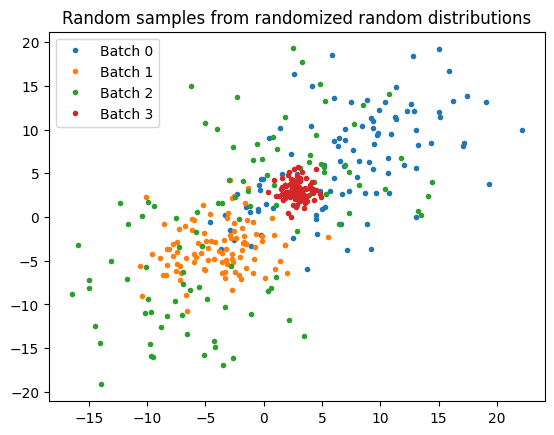

In [29]:
from numpy import dtype
from torch import Tensor


DIM = 2
SAMPLE_SIZE = 100
NUM_BATCHES = 4
PARENT_COVAR_SCALE = 100

def sample_random_random_batch(dim: int=DIM, sample_size:int=SAMPLE_SIZE) -> Tensor:
        """
        Sample a random batch of vectors from a randomized random distribution.
        See this as a 'black box' function that 
        generates magical unpredictable data.

        Arguments:
        * dim: length of output vectors.
        * sample_size: number of output vectors.

        Returns:
        * `dim×sample_size` matrix of `sample_size` column vectors of
                length `dim`.

        """
        parent_mean = torch.from_numpy((RNG.random(size=dim)-0.5)*10).to(torch.float)
        covar_scale=RNG.integers(low=1, high=100)
        distr = randomized_multinormal_distr(dim, parent_mean=parent_mean,
                covar_scale=covar_scale)
        output = distr.sample((sample_size,)).reshape(dim, sample_size)
        assert(output.shape == (dim, sample_size))
        return output
        


batches = []
for _ in range(NUM_BATCHES):
        batch = sample_random_random_batch()
        batches.append(batch)

fig, ax = plt.subplots(nrows=1, ncols=1)
i = 0
for batch in batches:
    x = batch[0,:]
    y = batch[1,:]
    ax.plot(x, y, ".", label=f"Batch {i}")
    i += 1
ax.legend()
ax.set_title("Random samples from randomized random distributions");


In [30]:
fig.savefig("whitening_random_random_data.pdf")

## Numerically comparing the different Whitening Transform implementations

In [31]:
import time
NUM_MEASUREMENTS = 100

def create_log() -> dict[str, Any]:
    output = {
        "mean_mses": [],
        "covar_mses": [],
        "runtimes": [],
        "num_failures": 0,
        "num_successes": 0
    }
    return output

def get_whiten_fun_with_fixed_eps(reg_eps: float):
    return lambda x : whiten(x, reg_eps)

setups = {
    "naive_whiten": (whiten_naive, create_log()),
    "reg_eps_0.00": (get_whiten_fun_with_fixed_eps(0), create_log()),
    "reg_eps_0.01": (get_whiten_fun_with_fixed_eps(0.01), create_log()),
    "reg_eps_0.05": (get_whiten_fun_with_fixed_eps(0.05), create_log()),
}

for i in range(NUM_MEASUREMENTS):
    batch = sample_random_random_batch()
    prev_log = None
    for (setup_name, (whiten_fun, log)) in setups.items():
        assert not (log is prev_log)
        prev_log = log
        
        try:
            start = time.time()
            whitened_batch = whiten_fun(batch)
            end = time.time()
            # runtime = timeit.timeit("whiten_fun(batch)", number=1)
        except:
            log["num_failures"] += 1
            continue
        mean_mse, covar_mse = compute_whiten_error(whitened_batch)
        log["num_successes"] += 1
        log["mean_mses"].append(mean_mse)
        log["covar_mses"].append(covar_mse)
        log["runtimes"].append(end-start)
        print(f"batch {i}: {setup_name} mse: {mean_mse:e}")
        
assert(setups["naive_whiten"][1]["mean_mses"] is not setups["reg_eps_0.00"][1]["mean_mses"])
print(setups["naive_whiten"][1]["mean_mses"][0], setups["reg_eps_0.00"][1]["mean_mses"][0])

batch 0: naive_whiten mse: 9.094948e-15
batch 0: reg_eps_0.00 mse: 6.392043e-15
batch 0: reg_eps_0.01 mse: 4.724399e-15
batch 0: reg_eps_0.05 mse: 4.519762e-15
batch 1: naive_whiten mse: 1.182343e-15
batch 1: reg_eps_0.00 mse: 1.637090e-15
batch 1: reg_eps_0.01 mse: 1.682565e-15
batch 1: reg_eps_0.05 mse: 1.818989e-16
batch 2: naive_whiten mse: 2.364686e-15
batch 2: reg_eps_0.00 mse: 2.151523e-15
batch 2: reg_eps_0.01 mse: 2.637535e-15
batch 2: reg_eps_0.05 mse: 1.932676e-15
batch 3: naive_whiten mse: 2.253842e-15
batch 3: reg_eps_0.00 mse: 2.637535e-15
batch 3: reg_eps_0.01 mse: 1.921307e-15
batch 3: reg_eps_0.05 mse: 2.273737e-15
batch 4: naive_whiten mse: 1.319447e-14
batch 4: reg_eps_0.00 mse: 4.013146e-15
batch 4: reg_eps_0.01 mse: 3.424816e-15
batch 4: reg_eps_0.05 mse: 4.322942e-15
batch 5: naive_whiten mse: 8.427036e-15
batch 5: reg_eps_0.00 mse: 7.199219e-15
batch 5: reg_eps_0.01 mse: 6.571099e-15
batch 5: reg_eps_0.05 mse: 6.571099e-15
batch 6: naive_whiten mse: 9.094947e-17


naive_whiten: 	mean:1.7958e-15, 	covar:1.8121e-01, 	runtime:1.6813e-04
reg_eps_0.00: 	mean:1.5178e-15, 	covar:1.5194e-14, 	runtime:1.9609e-04
reg_eps_0.01: 	mean:1.6082e-15, 	covar:4.7811e-05, 	runtime:1.8138e-04
reg_eps_0.05: 	mean:1.5568e-15, 	covar:1.2949e-03, 	runtime:1.7987e-04


/tmp/ipykernel_5957/1418892832.py:43: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(f, float_format="{:0.4e}".format, index = False,


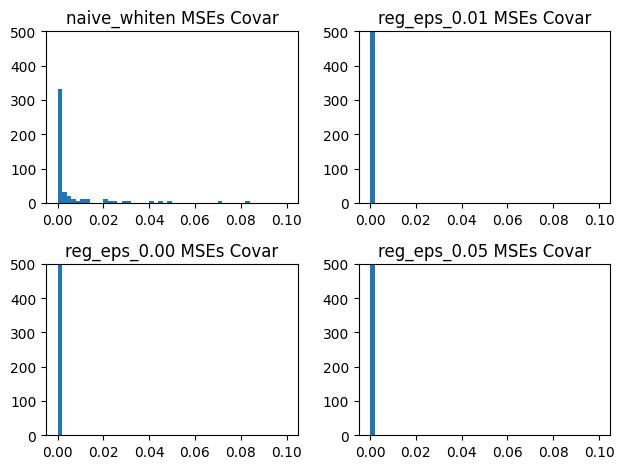

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2)
row = 0
col = 0

columns = ("Algorithm",) + tuple(setups["naive_whiten"][1].keys())
df = pd.DataFrame(columns=columns, index = setups.keys())
df["Algorithm"] = setups.keys()

for setup_name in setups.keys():
    log = setups[setup_name][1]

    ax = axes[row, col]
    ax.set_title(setup_name + " MSEs Covar")
    ax.hist(log["covar_mses"], bins=50, range=[0, 0.1], density=True)
    ax.set_ylim([0, 500])

    row += 1
    if row >= 2:
        row = 0
        col += 1

    mean_mean_mse = np.mean(log["mean_mses"])
    mean_covar_mse = np.mean(log["covar_mses"])
    mean_runtime = np.mean(log["runtimes"])
    print(f"{setup_name}: \tmean:{mean_mean_mse:.4e}, \tcovar:{mean_covar_mse:.4e}, \truntime:{mean_runtime:.4e}")

    df.loc[setup_name, "mean_mses"] = np.mean(log["mean_mses"])
    df.loc[setup_name, "covar_mses"] = np.mean(log["covar_mses"])
    df.loc[setup_name, "runtimes"] = np.mean(log["runtimes"])
    df.loc[setup_name, "num_failures"] = log["num_failures"]
    df.loc[setup_name, "num_successes"] = log["num_successes"]

plt.tight_layout()

row_names_format = {
    "naive_whiten": "Naive",
    "reg_eps_0.00": r"$\varepsilon=0$",
    "reg_eps_0.01": r"$\varepsilon=0.01$",
    "reg_eps_0.05": r"$\varepsilon=0.05$"
}

with open("whitening_latex_table.tex", "w") as f:
    df.to_latex(f, float_format="{:0.4e}".format, index = False, 
                formatters={"Algorithm": lambda x: row_names_format[x] },
                escape=False,
                columns=columns[:-2], # Don't print num_successes and num_errors
                header=["Algorithm", "Mean MSE of Mean","Mean MSE of Covariance", "Runtime"])

Outputs are typically like:

```
naive_whiten: 	mean:3.1602e-15, 	covar:1.9646e-01, 	runtime:1.4660e-04
reg_eps_0.00: 	mean:2.9785e-15, 	covar:1.9522e-14, 	runtime:1.6805e-04
reg_eps_0.01: 	mean:3.1532e-15, 	covar:4.7498e-05, 	runtime:1.7676e-04
reg_eps_0.05: 	mean:3.0209e-15, 	covar:1.2862e-03, 	runtime:1.5743e-04
```

Note that the naive whitening implementation produces orders
of magnitude larger covariance errors than the alternative implementation.
As expected, regularization introduces some error. But still less than the naive method!

Well, for robustness, we can use ~~ANOVA~~ (**it is not normally distributed!
Looks more like exponential. Try Wilcoxon!**) to test if the mean covariance
error between the naive and alternative(ε=0) are statistically significantly different.


In [33]:
naive_covar_erros = setups["naive_whiten"][1]["covar_mses"]
alternative_covar_erros = setups["reg_eps_0.00"][1]["covar_mses"]
f_val, p_val = stats.wilcoxon(naive_covar_erros, alternative_covar_erros)
print(f"Wilcoxon p-value naive covar errors significant different mean: {p_val:.10f}")

Wilcoxon p-value naive covar errors significant different mean: 0.0000000000
